In [3]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=40813d650637657b4593ba2602a1686121c4cf8a6f619673fbfb90b73cc47ca6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=899382a2c10e52c2f67bb89091c06b0d2270a90e6fc81f596f06d7a6adf30bea
  Stored in directory: /root/.cache/pip/w

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [4]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 18.43 MiB/s, done.


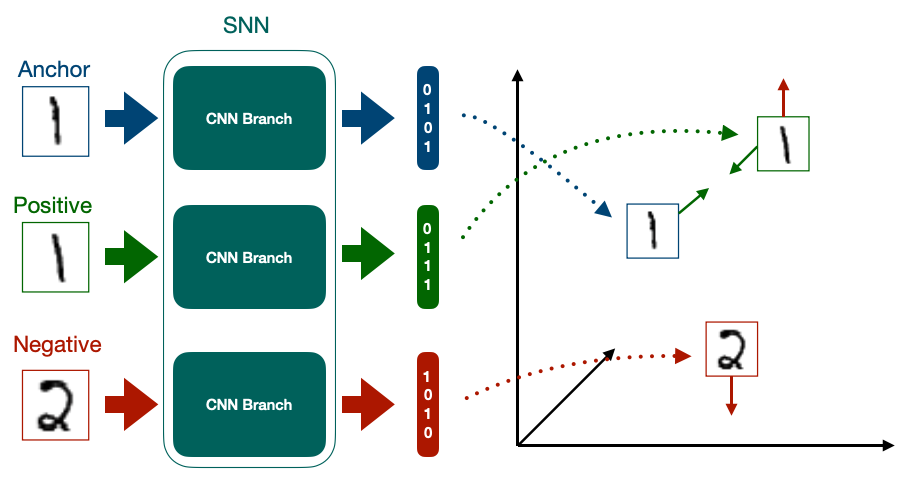

# Imports

In [5]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [7]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [9]:
row = df.iloc[14]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

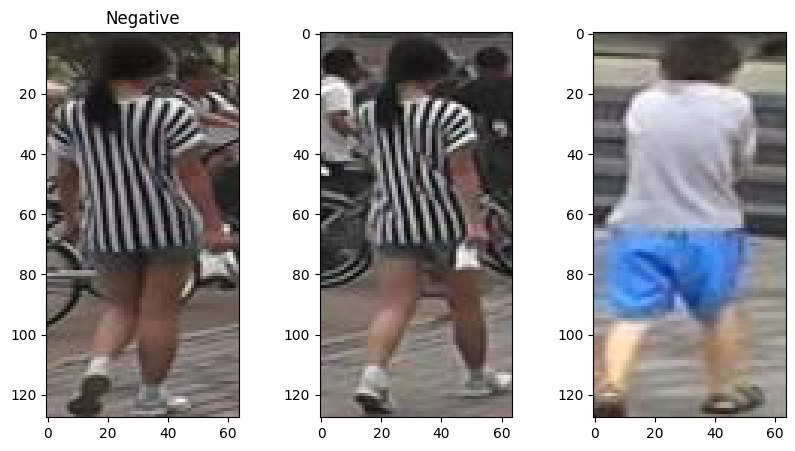

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
ax1.set_title("Anchor")
ax1.imshow(A_img)

ax1.set_title("Positive")
ax2.imshow(P_img)

ax1.set_title("Negative")
ax3.imshow(N_img)

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset 

In [12]:
class APN_Dataset(Dataset):
  
  def __init__(self, df):
    # super(APN_Dataset, self).__init__()
    self.df = df

  def __len__(self):
    return len(self.df)  

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

    return A_img, P_img, N_img

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"size of train set: {len(trainset)}")
print(f"size of valid set: {len(validset)}")

size of train set: 3200
size of valid set: 800


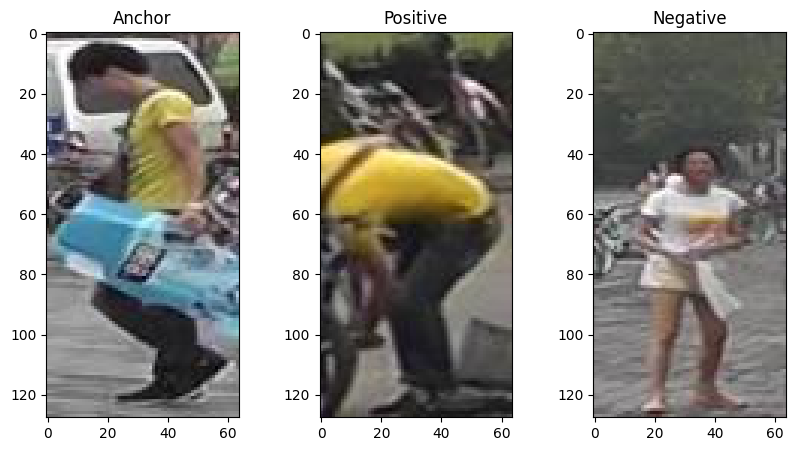

In [14]:
idx = 40
A,P,N =  trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [15]:

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [17]:
for A, P, N in trainloader:
  break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [18]:
class APN_Model(nn.Module):

  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embedings = self.efficientnet(images)

    return embedings  

In [ ]:
model = APN_Model()
model.to(DEVICE)

# Create Train and Eval function

In [36]:
def train_fn(model, dataloader, optimizer, criterion): # criterion is the loss function
  model.train() # it will turn on the layers of drop out and batch normalization
  total_loss = 0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)
      loss = criterion(A_embs, P_embs, N_embs) # we are using triplet loss here
    
      optimizer.zero_grad()
      loss.requires_grad = True
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    return total_loss / len(dataloader)
  

In [37]:
def eval_fn(model, dataloader, criterion): # criterion is the loss function
  model.eval() # OFF dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)
      loss = criterion(A_embs, P_embs, N_embs) # we are using triplet loss here
    
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [38]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [39]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")  

100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.9448227435350418 valid_loss : 1.0180787968635558


100%|██████████| 25/25 [00:03<00:00,  8.05it/s]


EPOCHS : 2 train_loss : 0.9577696895599366 valid_loss : 1.0297438979148865


100%|██████████| 25/25 [00:02<00:00,  9.19it/s]


EPOCHS : 3 train_loss : 0.9615924233198165 valid_loss : 1.018736801147461


100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


EPOCHS : 4 train_loss : 0.9516595554351807 valid_loss : 1.0205708384513854


100%|██████████| 25/25 [00:02<00:00,  9.25it/s]


EPOCHS : 5 train_loss : 0.9570395559072494 valid_loss : 1.0298220777511597


100%|██████████| 25/25 [00:02<00:00,  9.21it/s]


EPOCHS : 6 train_loss : 0.9606175947189332 valid_loss : 1.0395104813575744


100%|██████████| 25/25 [00:02<00:00,  9.16it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 7 train_loss : 0.9465020579099656 valid_loss : 1.008313467502594


100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


EPOCHS : 8 train_loss : 0.953292515873909 valid_loss : 1.022231595516205


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


EPOCHS : 9 train_loss : 0.9588937169313431 valid_loss : 1.0216427373886108


100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


EPOCHS : 10 train_loss : 0.9521327704191208 valid_loss : 1.0133720183372497


100%|██████████| 25/25 [00:02<00:00,  9.21it/s]


EPOCHS : 11 train_loss : 0.9609844917058945 valid_loss : 1.0274976801872253


100%|██████████| 25/25 [00:02<00:00,  9.25it/s]


EPOCHS : 12 train_loss : 0.9495434534549713 valid_loss : 1.0194261860847473


100%|██████████| 25/25 [00:02<00:00,  9.21it/s]


EPOCHS : 13 train_loss : 0.9585162943601608 valid_loss : 1.014861788749695


100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


EPOCHS : 14 train_loss : 0.9570062172412872 valid_loss : 1.0276693105697632


100%|██████████| 25/25 [00:03<00:00,  8.17it/s]

EPOCHS : 15 train_loss : 0.9589670765399932 valid_loss : 1.022600781917572


# Get Anchor Embeddings

In [40]:
def get_encodings_csv(anc_img_model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc


In [41]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encodings_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:41<00:00, 96.10it/s] 


In [42]:
df_enc.to_csv('database.csv', index=False)

# Inference

In [51]:
def euclidean_dist(img_enc, anc_enc_arr): # we're going to compare that image to the entire database
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist


In [52]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0
model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [53]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_enc_names = df_enc['Anchor']

In [54]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1, :])
  distance = np.append(distance, dist)

In [55]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


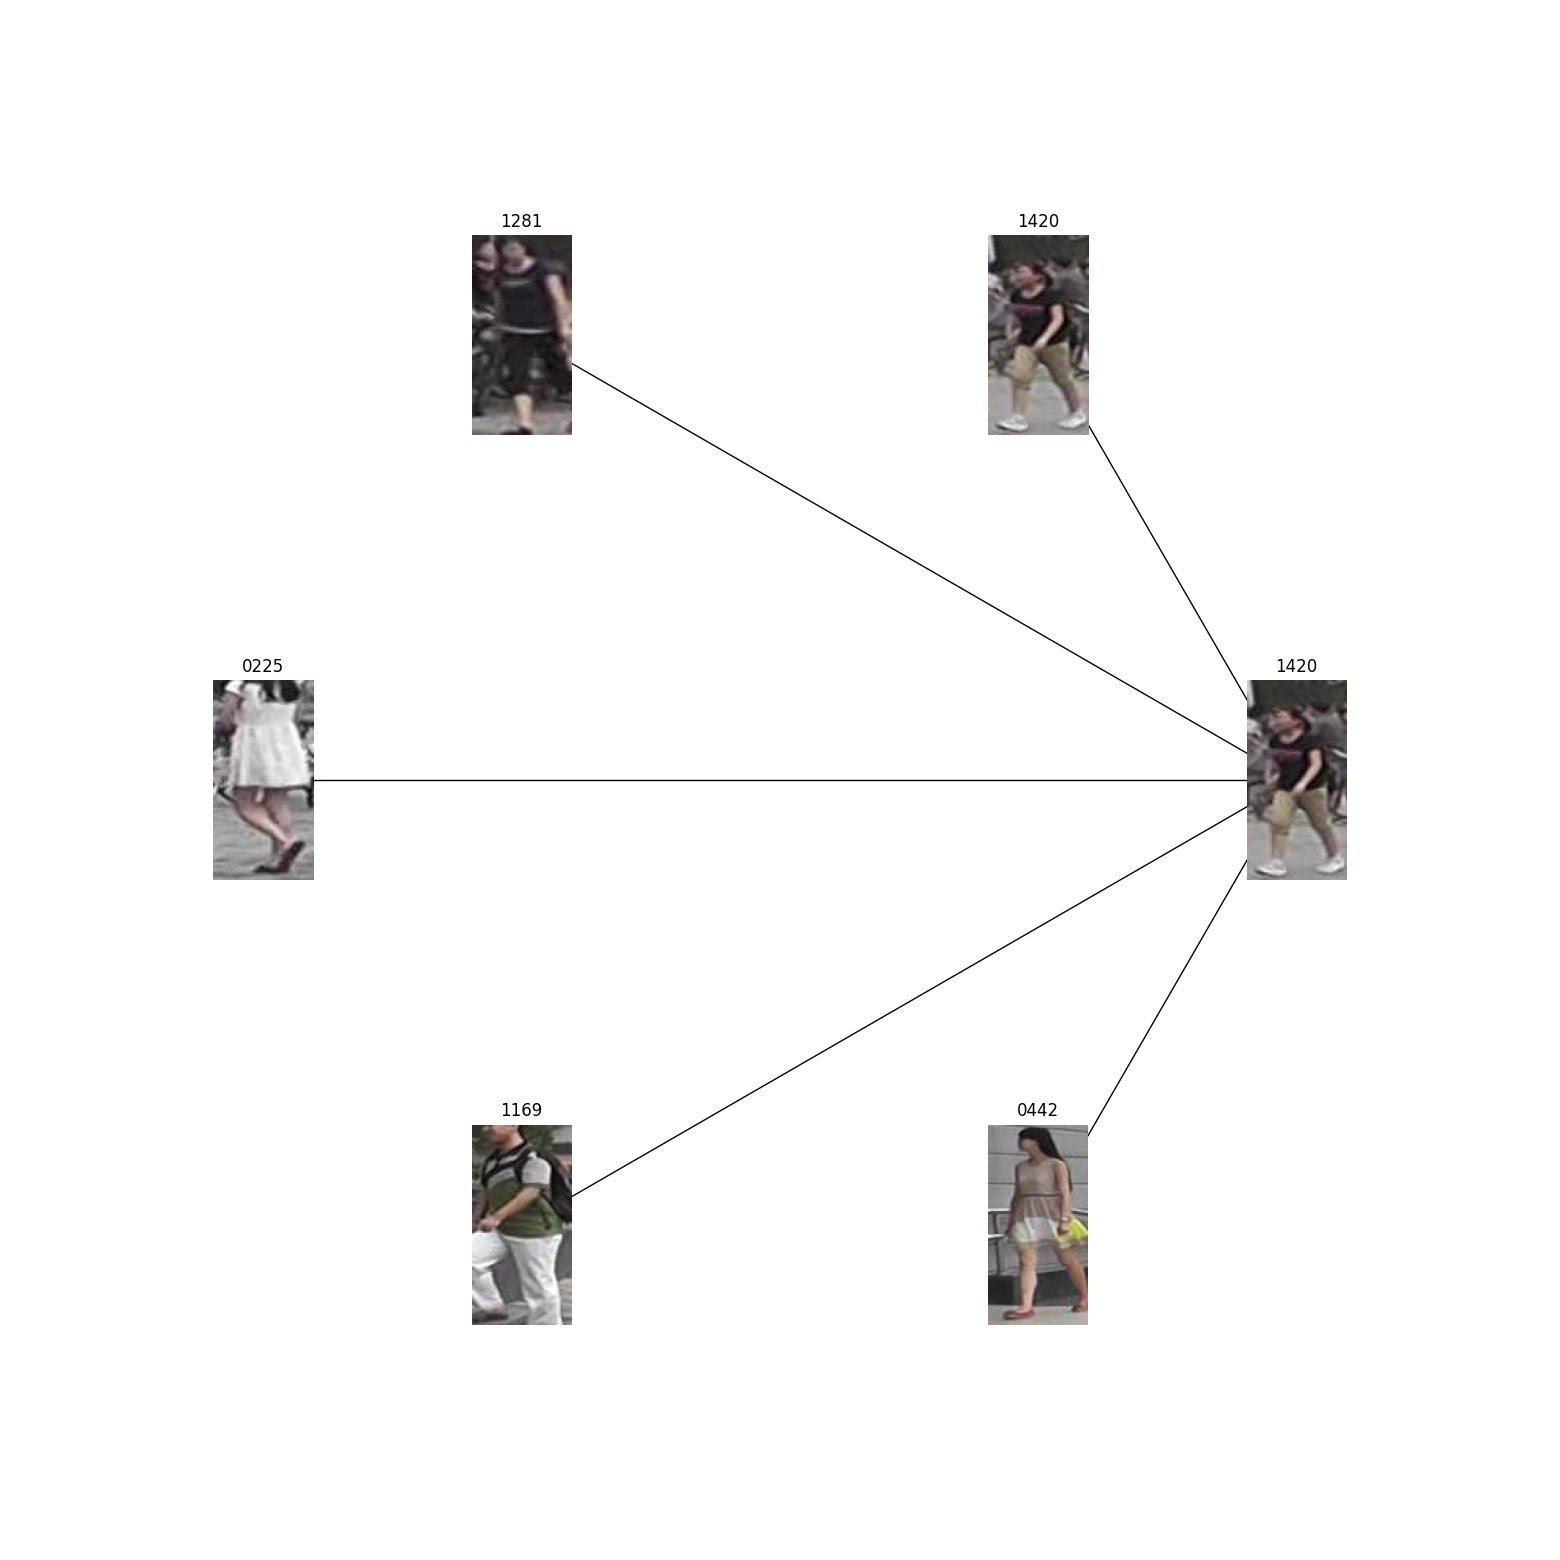

In [57]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_enc_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);